# 第06章: 06 Svm And Kernels

## 📋 この章で学ぶこと

この章を終えると、以下ができるようになります：

- [ ] この章の内容を理解できる

## 🎯 前提知識

この章を学ぶには以下の知識が必要です：

- ✅ Python基礎

⏱️ **推定学習時間**: 60-90分  
📊 **難易度**: ★★★☆☆（中級）  
🎓 **カテゴリ**: 機械学習

---


## 💡 イントロダクション：なぜこれを学ぶのか？

### モチベーション

[この章の重要性を説明]

### 実世界での応用

[具体的な応用例]

---


In [1]:
# ============================================================
# [コードの説明]
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification, make_moons, make_circles, make_blobs
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score, classification_report

np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')

**生成されたデータの特徴**：
- 各サンプルは複数の特徴量を持つ
- 各サンプルには正解ラベル（クラス）が割り当てられている
- 特徴量は正規化されていない生の値

このデータを可視化すると、クラス間の分離度が確認できます。
分離が明確なほど、モデルの学習は容易になります。

## Part 1: Linear SVM Fundamentals

In [2]:
# Generate linearly separable data
X, y = make_blobs(n_samples=100, centers=2, cluster_std=1.0, random_state=42)

# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train Linear SVM
svm_linear = SVC(kernel='linear', C=1.0)
svm_linear.fit(X_scaled, y)

print(f"Number of support vectors: {len(svm_linear.support_vectors_)}")
print(f"Support vectors per class: {svm_linear.n_support_}")

Number of support vectors: 2
Support vectors per class: [1 1]


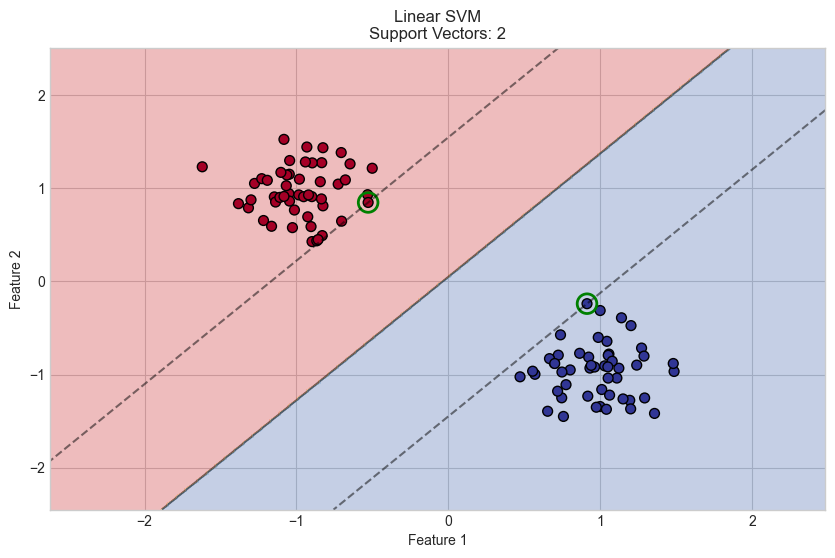

In [3]:
# Visualize SVM with margins
def plot_svm_decision_boundary(model, X, y, ax, title):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Decision boundary and margins
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)
    
    # Plot decision function for margins
    if hasattr(model, 'decision_function'):
        Z_decision = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z_decision = Z_decision.reshape(xx.shape)
        ax.contour(xx, yy, Z_decision, colors='k', levels=[-1, 0, 1], 
                   alpha=0.5, linestyles=['--', '-', '--'])
    
    # Plot data points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='black', s=50)
    
    # Highlight support vectors
    ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
               s=200, facecolors='none', edgecolors='green', linewidths=2)
    
    ax.set_title(title)

plt.figure(figsize=(10, 6))
ax = plt.gca()
plot_svm_decision_boundary(svm_linear, X_scaled, y, ax, 
                          f'Linear SVM\nSupport Vectors: {len(svm_linear.support_vectors_)}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

**予測結果の使い方**：
- 予測値と実際の値を比較して精度を評価
- 誤った予測のパターンを分析
- 予測確率を見て、モデルの確信度を確認

予測が完璧でないのは正常です。重要なのは、
実用に耐える精度かどうかを判断することです。

## Part 2: Effect of C Parameter (Regularization)

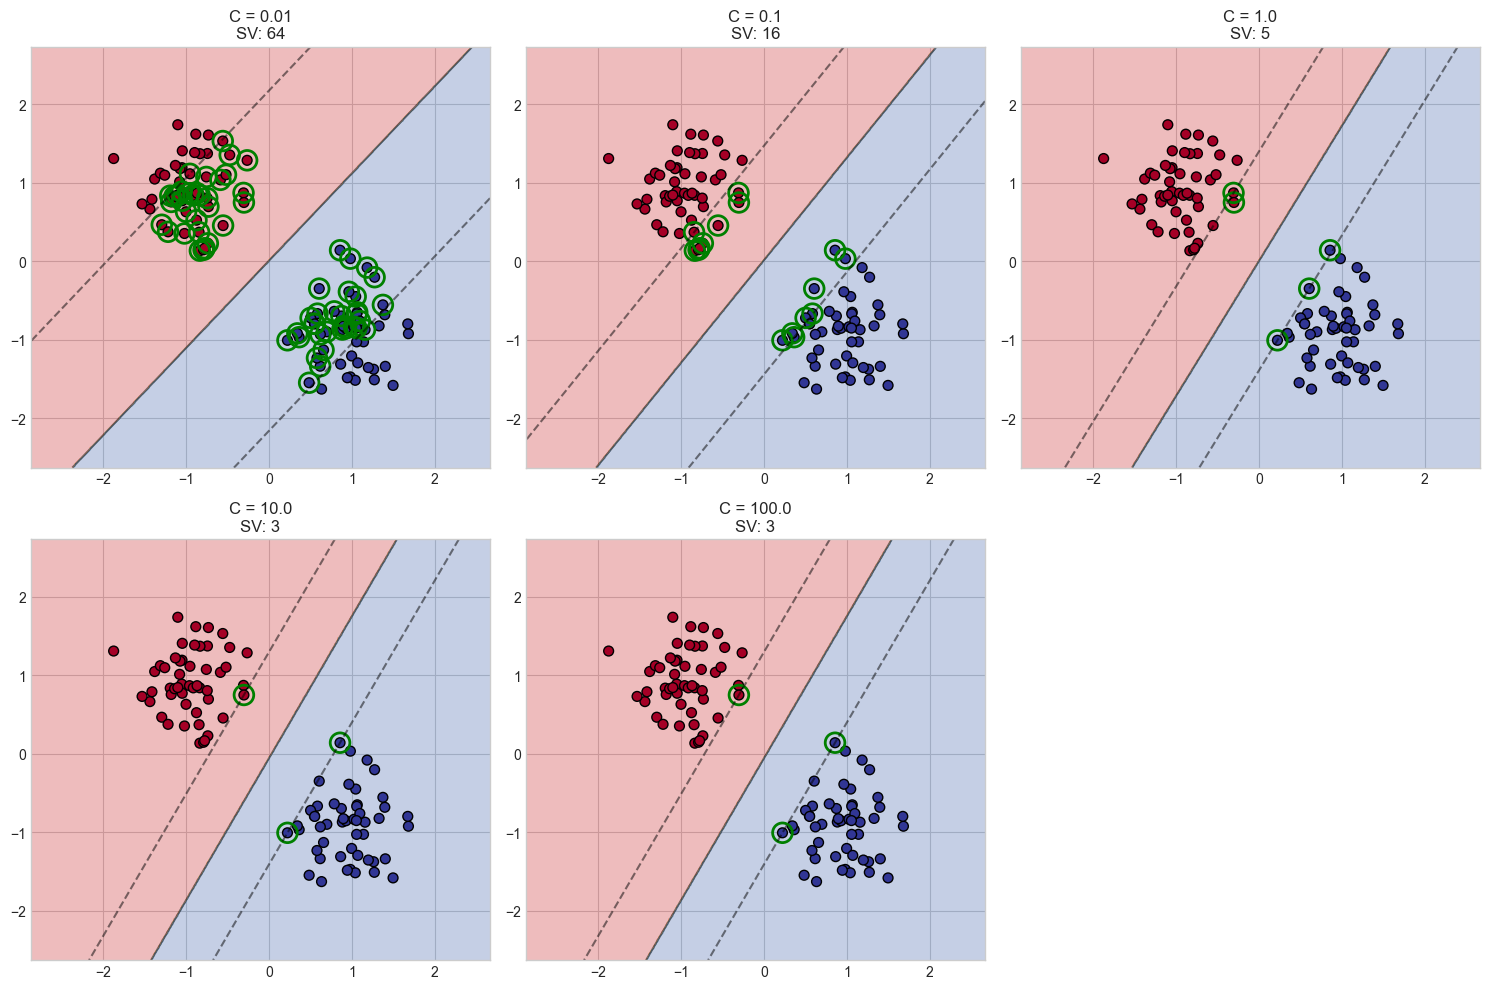


C parameter interpretation:
- Small C: Wider margin, more misclassifications allowed (soft margin)
- Large C: Narrow margin, fewer misclassifications (hard margin)


In [4]:
# ============================================================
# [コードの説明]
# ============================================================

# Generate data with some overlap
X, y = make_blobs(n_samples=100, centers=2, cluster_std=1.5, random_state=42)
X_scaled = scaler.fit_transform(X)

# Compare different C values
C_values = [0.01, 0.1, 1.0, 10.0, 100.0]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, C in enumerate(C_values):
    svm = SVC(kernel='linear', C=C)
    svm.fit(X_scaled, y)
    
    plot_svm_decision_boundary(svm, X_scaled, y, axes[idx], 
                              f'C = {C}\nSV: {len(svm.support_vectors_)}')

axes[-1].axis('off')
plt.tight_layout()
plt.show()

print("\nC parameter interpretation:")
print("- Small C: Wider margin, more misclassifications allowed (soft margin)")
print("- Large C: Narrow margin, fewer misclassifications (hard margin)")

**可視化の重要性**：
データや結果をグラフで表示すると、以下のことが分かります：
- データの分布や傾向
- クラス間の分離度
- 外れ値の存在
- モデルの決定境界

「百聞は一見にしかず」です。複雑なデータも、
グラフにすれば一目で特徴を理解できます。

## Part 3: Non-linear Data and Kernels

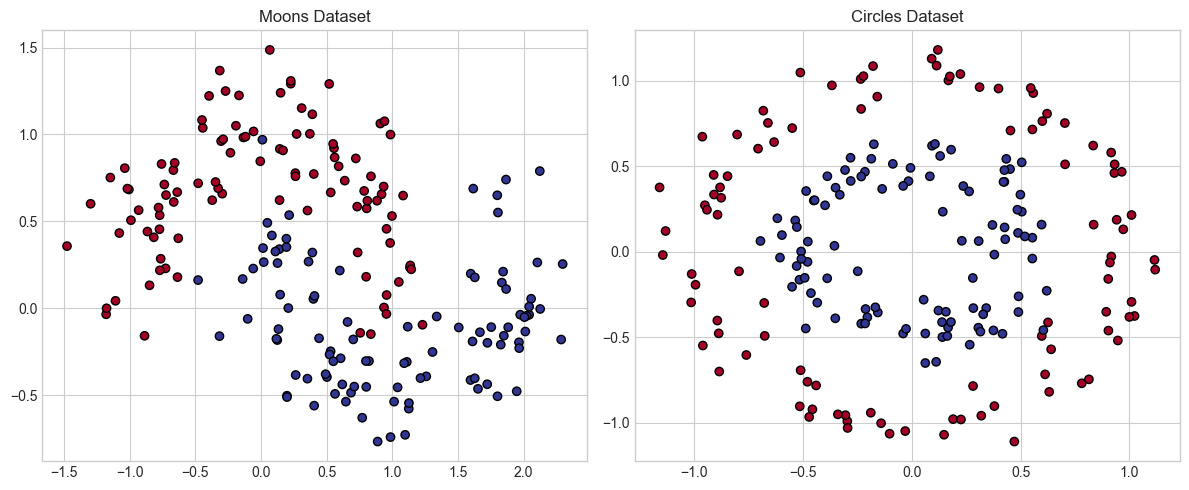

In [5]:
# Generate non-linearly separable data
X_moons, y_moons = make_moons(n_samples=200, noise=0.2, random_state=42)
X_circles, y_circles = make_circles(n_samples=200, noise=0.1, factor=0.5, random_state=42)

# Scale
X_moons_scaled = scaler.fit_transform(X_moons)
X_circles_scaled = scaler.fit_transform(X_circles)

# Visualize datasets
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap='RdYlBu', edgecolors='black')
axes[0].set_title('Moons Dataset')

axes[1].scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles, cmap='RdYlBu', edgecolors='black')
axes[1].set_title('Circles Dataset')

plt.tight_layout()
plt.show()

**可視化の重要性**：
データや結果をグラフで表示すると、以下のことが分かります：
- データの分布や傾向
- クラス間の分離度
- 外れ値の存在
- モデルの決定境界

「百聞は一見にしかず」です。複雑なデータも、
グラフにすれば一目で特徴を理解できます。

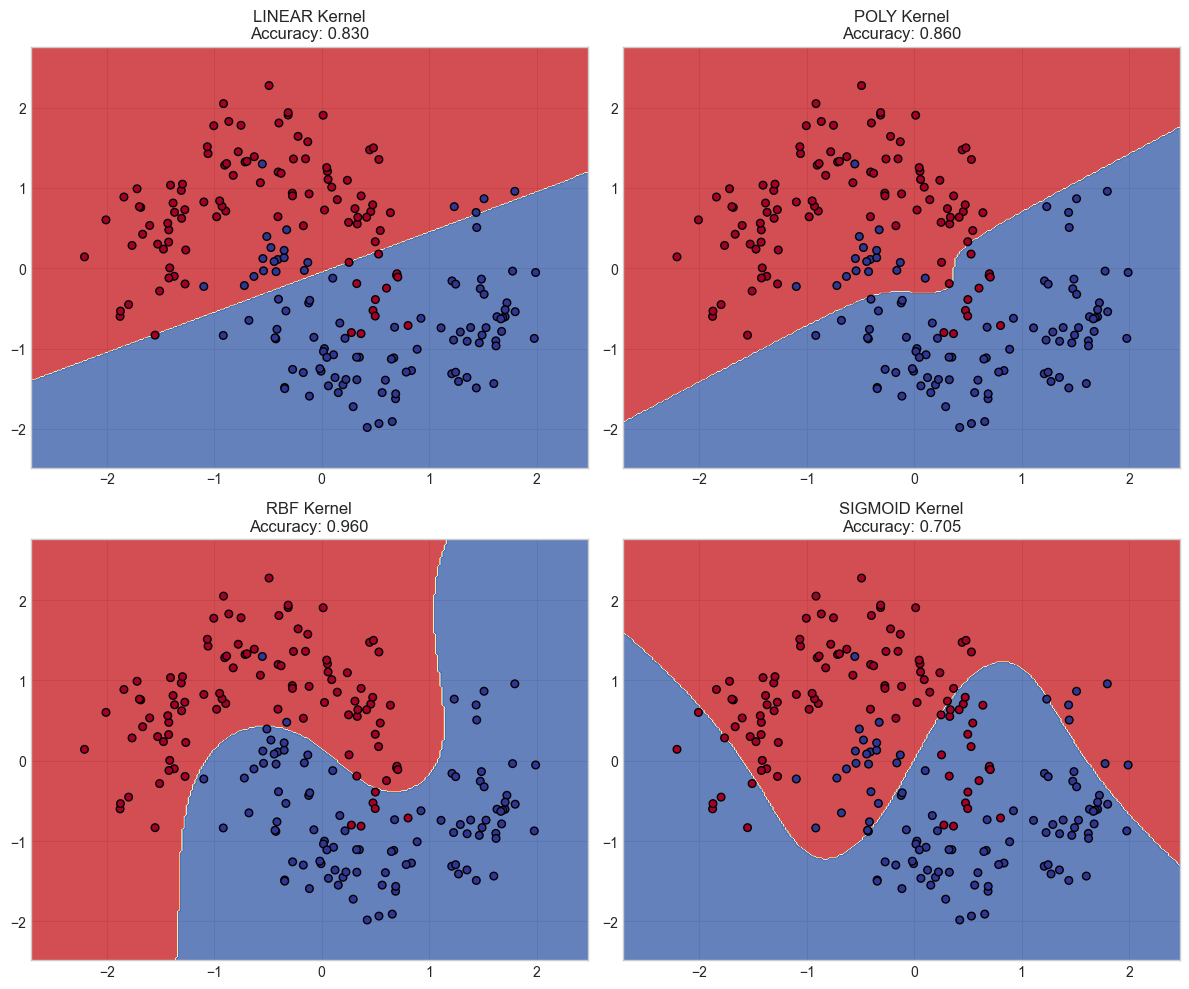

In [6]:
# ============================================================
# [コードの説明]
# ============================================================

# Compare kernels on moons data
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, kernel in enumerate(kernels):
    svm = SVC(kernel=kernel, C=1.0, gamma='scale')
    svm.fit(X_moons_scaled, y_moons)
    
    acc = svm.score(X_moons_scaled, y_moons)
    
    # Simple decision boundary plot
    h = 0.02
    x_min, x_max = X_moons_scaled[:, 0].min() - 0.5, X_moons_scaled[:, 0].max() + 0.5
    y_min, y_max = X_moons_scaled[:, 1].min() - 0.5, X_moons_scaled[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    axes[idx].contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
    axes[idx].scatter(X_moons_scaled[:, 0], X_moons_scaled[:, 1], c=y_moons, 
                      cmap=plt.cm.RdYlBu, edgecolors='black', s=30)
    axes[idx].set_title(f'{kernel.upper()} Kernel\nAccuracy: {acc:.3f}')

plt.tight_layout()
plt.show()

**予測結果の使い方**：
- 予測値と実際の値を比較して精度を評価
- 誤った予測のパターンを分析
- 予測確率を見て、モデルの確信度を確認

予測が完璧でないのは正常です。重要なのは、
実用に耐える精度かどうかを判断することです。

## Part 4: RBF Kernel - Gamma Parameter

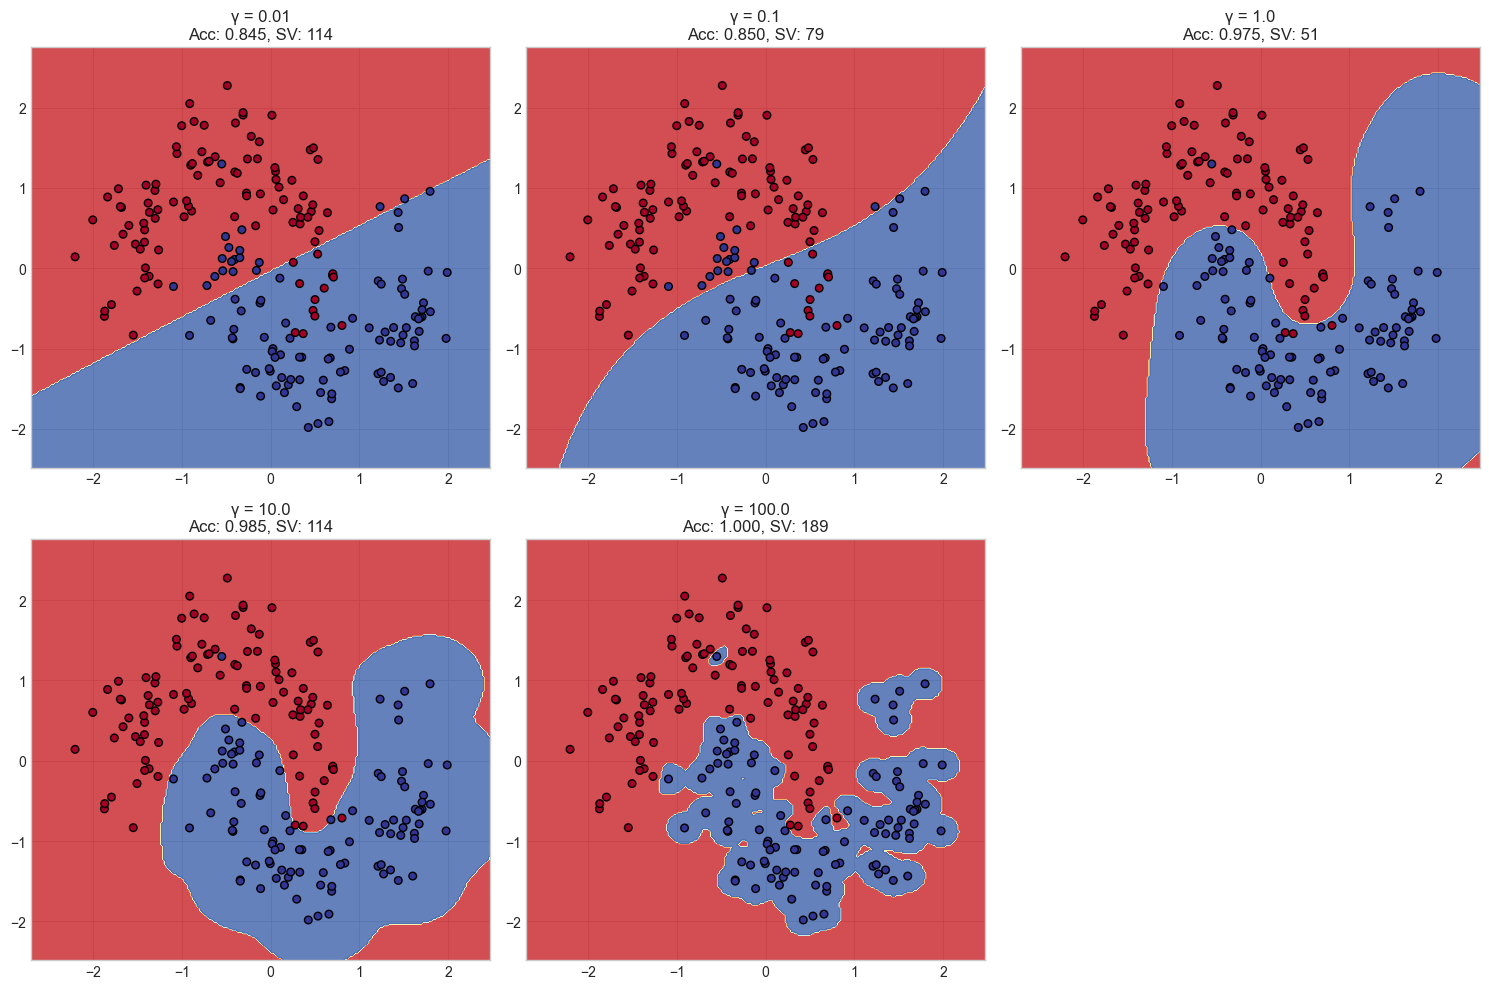


Gamma parameter interpretation:
- Small gamma: Smooth decision boundary, may underfit
- Large gamma: Complex decision boundary, may overfit


In [7]:
# ============================================================
# [コードの説明]
# ============================================================

# Effect of gamma on RBF kernel
gamma_values = [0.01, 0.1, 1.0, 10.0, 100.0]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, gamma in enumerate(gamma_values):
    svm = SVC(kernel='rbf', C=1.0, gamma=gamma)
    svm.fit(X_moons_scaled, y_moons)
    
    acc = svm.score(X_moons_scaled, y_moons)
    
    # Plot decision boundary
    h = 0.02
    x_min, x_max = X_moons_scaled[:, 0].min() - 0.5, X_moons_scaled[:, 0].max() + 0.5
    y_min, y_max = X_moons_scaled[:, 1].min() - 0.5, X_moons_scaled[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    axes[idx].contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
    axes[idx].scatter(X_moons_scaled[:, 0], X_moons_scaled[:, 1], c=y_moons, 
                      cmap=plt.cm.RdYlBu, edgecolors='black', s=30)
    axes[idx].set_title(f'γ = {gamma}\nAcc: {acc:.3f}, SV: {len(svm.support_vectors_)}')

axes[-1].axis('off')
plt.tight_layout()
plt.show()

print("\nGamma parameter interpretation:")
print("- Small gamma: Smooth decision boundary, may underfit")
print("- Large gamma: Complex decision boundary, may overfit")

**予測結果の使い方**：
- 予測値と実際の値を比較して精度を評価
- 誤った予測のパターンを分析
- 予測確率を見て、モデルの確信度を確認

予測が完璧でないのは正常です。重要なのは、
実用に耐える精度かどうかを判断することです。

## Part 5: C and Gamma Grid Search

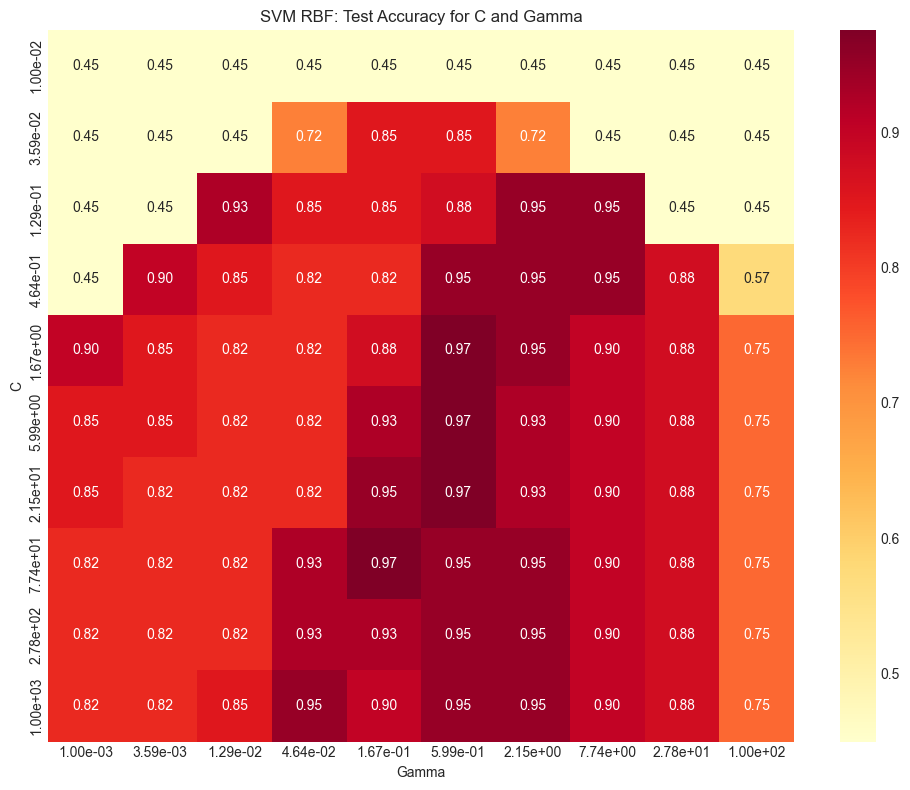


Best C: 1.6681
Best gamma: 0.5995
Best accuracy: 0.9750


In [8]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_moons_scaled, y_moons, test_size=0.2, random_state=42
)

# Parameter grid
C_range = np.logspace(-2, 3, 10)
gamma_range = np.logspace(-3, 2, 10)

# Grid search results
results = np.zeros((len(C_range), len(gamma_range)))

for i, C in enumerate(C_range):
    for j, gamma in enumerate(gamma_range):
        svm = SVC(kernel='rbf', C=C, gamma=gamma)
        svm.fit(X_train, y_train)
        results[i, j] = svm.score(X_test, y_test)

# Visualize as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(results, annot=True, fmt='.2f', cmap='YlOrRd',
            xticklabels=[f'{g:.2e}' for g in gamma_range],
            yticklabels=[f'{c:.2e}' for c in C_range])
plt.xlabel('Gamma')
plt.ylabel('C')
plt.title('SVM RBF: Test Accuracy for C and Gamma')
plt.tight_layout()
plt.show()

# Find best parameters
best_idx = np.unravel_index(np.argmax(results), results.shape)
print(f"\nBest C: {C_range[best_idx[0]]:.4f}")
print(f"Best gamma: {gamma_range[best_idx[1]]:.4f}")
print(f"Best accuracy: {results[best_idx]:.4f}")

**分割後のデータ**：
- `X_train`, `y_train`: モデルの学習に使用
- `X_test`, `y_test`: モデルの評価に使用

`random_state`パラメータを設定することで、
実験の再現性を確保できます（毎回同じ分割結果）。

In [9]:
# ============================================================
# [コードの説明]
# ============================================================

# Use GridSearchCV for proper cross-validation
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 10],
    'kernel': ['rbf']
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("GridSearchCV Results:")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")
print(f"Test score: {grid_search.score(X_test, y_test):.4f}")

GridSearchCV Results:
Best parameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Best CV score: 0.9750
Test score: 0.9500


**スコアの解釈**：
- 1.0に近いほど高精度
- 問題の難易度によって「良いスコア」の基準は異なる
- ベースライン（ランダム予測やシンプルなルール）と比較することが重要

**次のステップ**：
- スコアが低い場合: 特徴量の追加、モデルの変更、パラメータ調整
- スコアが高すぎる場合: 過学習の可能性を疑う
- バランスが良い場合: 他の評価指標も確認

## Part 6: Polynomial Kernel

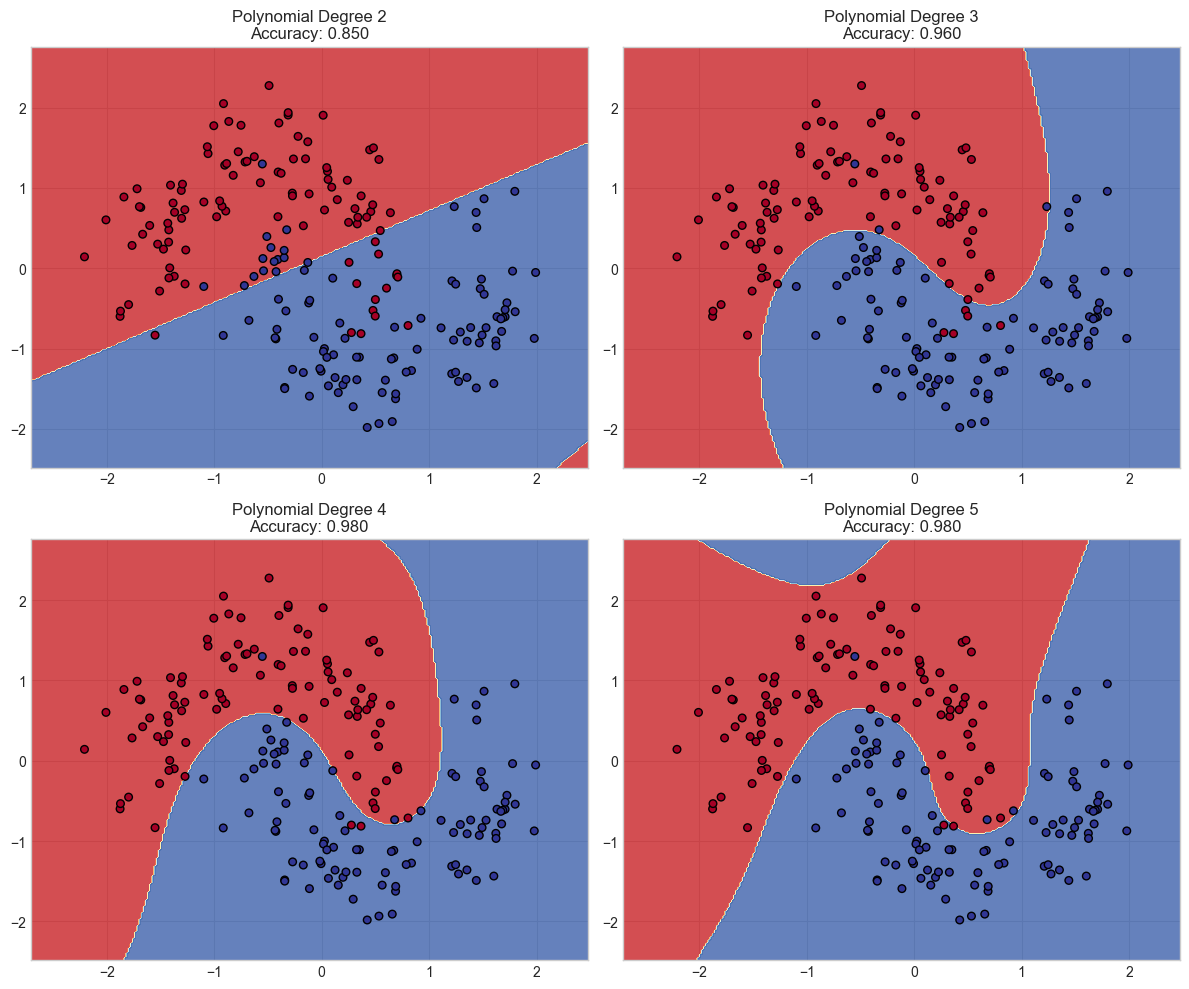

In [10]:
# ============================================================
# [コードの説明]
# ============================================================

# Compare polynomial degrees
degrees = [2, 3, 4, 5]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, degree in enumerate(degrees):
    svm = SVC(kernel='poly', degree=degree, C=1.0, coef0=1)
    svm.fit(X_moons_scaled, y_moons)
    
    acc = svm.score(X_moons_scaled, y_moons)
    
    # Plot
    h = 0.02
    x_min, x_max = X_moons_scaled[:, 0].min() - 0.5, X_moons_scaled[:, 0].max() + 0.5
    y_min, y_max = X_moons_scaled[:, 1].min() - 0.5, X_moons_scaled[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    axes[idx].contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
    axes[idx].scatter(X_moons_scaled[:, 0], X_moons_scaled[:, 1], c=y_moons, 
                      cmap=plt.cm.RdYlBu, edgecolors='black', s=30)
    axes[idx].set_title(f'Polynomial Degree {degree}\nAccuracy: {acc:.3f}')

plt.tight_layout()
plt.show()

**予測結果の使い方**：
- 予測値と実際の値を比較して精度を評価
- 誤った予測のパターンを分析
- 予測確率を見て、モデルの確信度を確認

予測が完璧でないのは正常です。重要なのは、
実用に耐える精度かどうかを判断することです。

## Part 7: Multi-class Classification

In [11]:
# Generate multi-class data
X_multi, y_multi = make_classification(
    n_samples=500, n_features=20, n_informative=10,
    n_classes=4, n_clusters_per_class=1, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X_multi, y_multi, test_size=0.2, random_state=42
)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVM
svm_multi = SVC(kernel='rbf', C=1.0, gamma='scale', decision_function_shape='ovr')
svm_multi.fit(X_train_scaled, y_train)

# Evaluate
y_pred = svm_multi.predict(X_test_scaled)

print("Multi-class SVM Classification Report:")
print(classification_report(y_test, y_pred))

Multi-class SVM Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.78      0.84        23
           1       0.91      0.91      0.91        33
           2       0.97      0.97      0.97        30
           3       0.82      1.00      0.90        14

    accuracy                           0.91       100
   macro avg       0.90      0.91      0.90       100
weighted avg       0.91      0.91      0.91       100



**生成されたデータの特徴**：
- 各サンプルは複数の特徴量を持つ
- 各サンプルには正解ラベル（クラス）が割り当てられている
- 特徴量は正規化されていない生の値

このデータを可視化すると、クラス間の分離度が確認できます。
分離が明確なほど、モデルの学習は容易になります。

## Part 8: SVM for Regression (SVR)

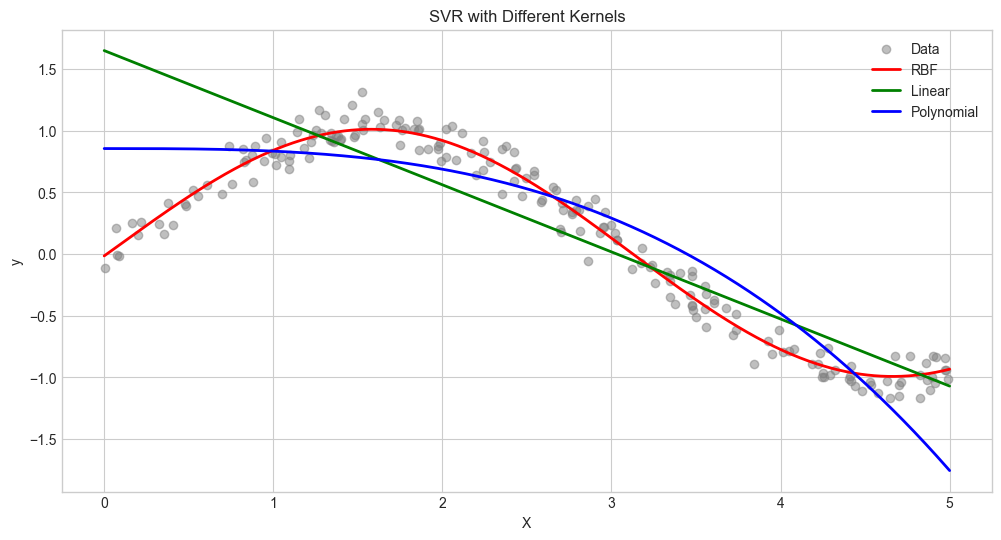

In [12]:
# Generate regression data
n_samples = 200
X_reg = np.sort(5 * np.random.rand(n_samples, 1), axis=0)
y_reg = np.sin(X_reg).ravel() + np.random.randn(n_samples) * 0.1

# Train different SVR models
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr_linear = SVR(kernel='linear', C=100)
svr_poly = SVR(kernel='poly', C=100, degree=3)

# Fit models
svr_rbf.fit(X_reg, y_reg)
svr_linear.fit(X_reg, y_reg)
svr_poly.fit(X_reg, y_reg)

# Predict
X_plot = np.linspace(0, 5, 1000).reshape(-1, 1)
y_rbf = svr_rbf.predict(X_plot)
y_linear = svr_linear.predict(X_plot)
y_poly = svr_poly.predict(X_plot)

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(X_reg, y_reg, c='gray', alpha=0.5, label='Data')
plt.plot(X_plot, y_rbf, 'r-', lw=2, label='RBF')
plt.plot(X_plot, y_linear, 'g-', lw=2, label='Linear')
plt.plot(X_plot, y_poly, 'b-', lw=2, label='Polynomial')
plt.xlabel('X')
plt.ylabel('y')
plt.title('SVR with Different Kernels')
plt.legend()
plt.show()

**学習完了後**：
- モデルは訓練データのパターンを記憶しています
- 新しいデータに対して予測できる状態になりました
- モデル内部のパラメータが最適化されています

次のステップは、このモデルを使ってテストデータで予測を行い、
性能を評価することです。

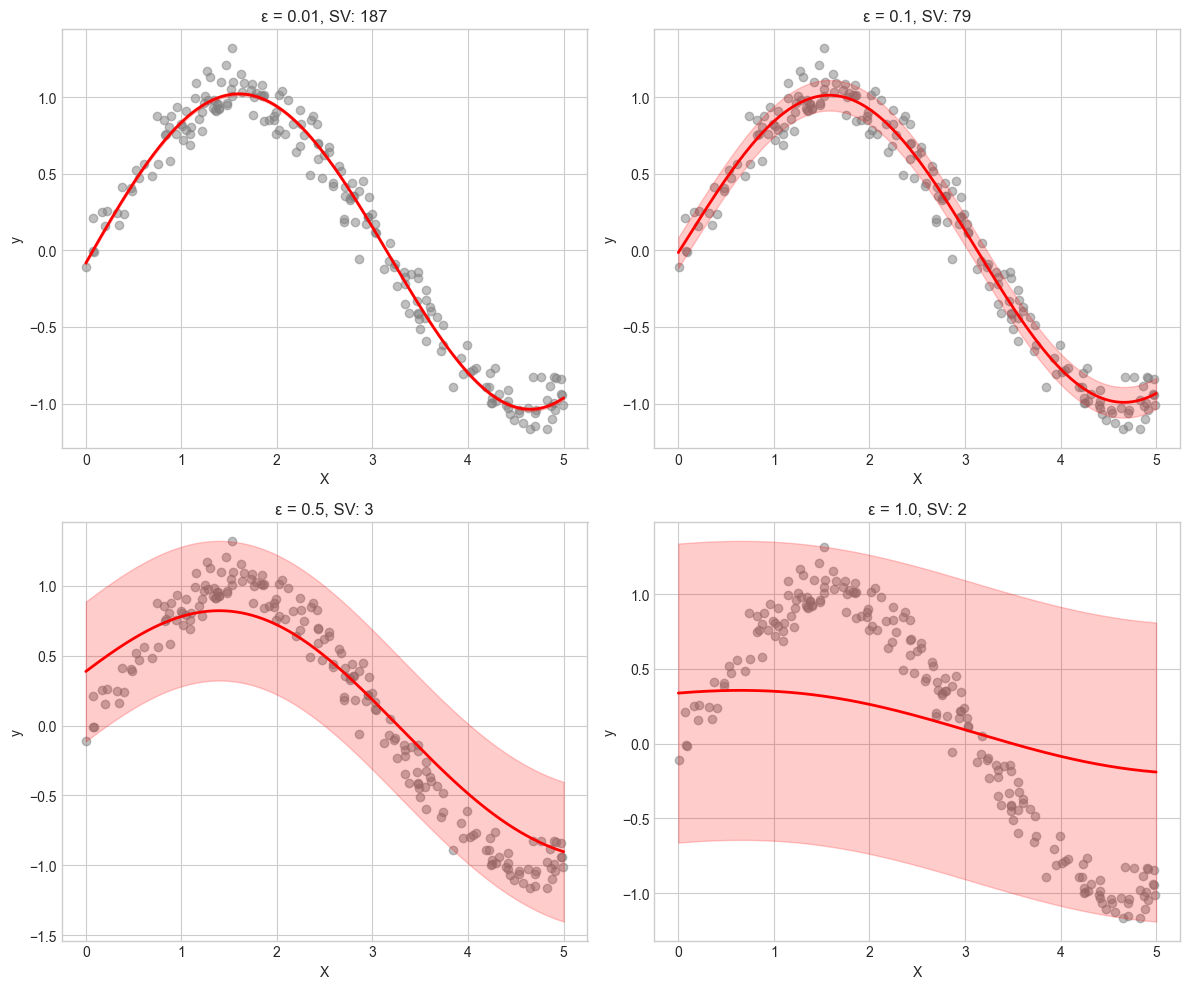

In [13]:
# ============================================================
# [コードの説明]
# ============================================================

# Effect of epsilon (tube width)
epsilons = [0.01, 0.1, 0.5, 1.0]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, eps in enumerate(epsilons):
    svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=eps)
    svr.fit(X_reg, y_reg)
    
    y_pred = svr.predict(X_plot)
    
    axes[idx].scatter(X_reg, y_reg, c='gray', alpha=0.5)
    axes[idx].plot(X_plot, y_pred, 'r-', lw=2)
    
    # Show epsilon tube
    axes[idx].fill_between(X_plot.ravel(), y_pred - eps, y_pred + eps, alpha=0.2, color='red')
    
    axes[idx].set_title(f'ε = {eps}, SV: {len(svr.support_)}')
    axes[idx].set_xlabel('X')
    axes[idx].set_ylabel('y')

plt.tight_layout()
plt.show()

**予測結果の使い方**：
- 予測値と実際の値を比較して精度を評価
- 誤った予測のパターンを分析
- 予測確率を見て、モデルの確信度を確認

予測が完璧でないのは正常です。重要なのは、
実用に耐える精度かどうかを判断することです。

## Part 9: Practical Example with Real-ish Data

In [14]:
# ============================================================
# [コードの説明]
# ============================================================

# Generate complex classification data
X, y = make_classification(
    n_samples=1000, n_features=20, n_informative=15,
    n_redundant=3, n_classes=3, n_clusters_per_class=2,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Compare different SVM configurations
configs = [
    ('Linear', SVC(kernel='linear', C=1.0)),
    ('RBF (C=1)', SVC(kernel='rbf', C=1.0, gamma='scale')),
    ('RBF (C=10)', SVC(kernel='rbf', C=10.0, gamma='scale')),
    ('Poly (d=3)', SVC(kernel='poly', degree=3, C=1.0))
]

print("SVM Configuration Comparison:")
print("="*50)

for name, model in configs:
    model.fit(X_train_scaled, y_train)
    
    train_acc = model.score(X_train_scaled, y_train)
    test_acc = model.score(X_test_scaled, y_test)
    n_sv = len(model.support_vectors_)
    
    print(f"\n{name}:")
    print(f"  Train Accuracy: {train_acc:.4f}")
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  Support Vectors: {n_sv} ({n_sv/len(X_train)*100:.1f}%)")

SVM Configuration Comparison:

Linear:
  Train Accuracy: 0.7288
  Test Accuracy: 0.7350
  Support Vectors: 498 (62.3%)

RBF (C=1):
  Train Accuracy: 0.9325
  Test Accuracy: 0.8450
  Support Vectors: 615 (76.9%)

RBF (C=10):
  Train Accuracy: 0.9975
  Test Accuracy: 0.8650
  Support Vectors: 537 (67.1%)

Poly (d=3):
  Train Accuracy: 0.9325
  Test Accuracy: 0.8000
  Support Vectors: 608 (76.0%)


**生成されたデータの特徴**：
- 各サンプルは複数の特徴量を持つ
- 各サンプルには正解ラベル（クラス）が割り当てられている
- 特徴量は正規化されていない生の値

このデータを可視化すると、クラス間の分離度が確認できます。
分離が明確なほど、モデルの学習は容易になります。

## Summary

In this notebook, you learned:

### SVM Fundamentals
- Maximum margin classifier
- Support vectors determine decision boundary
- Works well with high-dimensional data

### Key Parameters
- **C**: Regularization (soft vs hard margin)
  - Small C → wider margin, more errors allowed
  - Large C → narrow margin, fewer errors
- **gamma**: RBF kernel parameter
  - Small γ → smooth boundary
  - Large γ → complex boundary
- **degree**: Polynomial kernel degree

### Kernels
- **Linear**: For linearly separable data
- **RBF**: Most versatile, good default
- **Polynomial**: Captures interactions

### Key Takeaways
- Always scale features before using SVM
- RBF kernel is usually a good starting point
- Grid search C and gamma together
- Number of support vectors indicates complexity

### Next Steps
Continue to **Notebook 07** for MLP fundamentals - the start of neural networks!

### ⚠️ よくあるエラー #1: データのスケーリング忘れ

機械学習モデル（特にニューラルネットワーク）でデータをスケーリングしないと性能が低下します。

**原因:**
1. `StandardScaler`を使わずに生データを入力
2. 訓練セットとテストセットで異なるscalerを使用

**✅ 解決法:**

```python
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # fit_transformではない！
```

---


### ⚠️ よくあるエラー #2: データリーク

テストセットの情報が訓練に漏れると、評価が不正確になります。

**原因:**
1. テストセットで`fit_transform`を使う
2. スケーリング前にデータ分割

**✅ 解決法:**

```python
# ✅ 正しい順序
# 1. データ分割
X_train, X_test, y_train, y_test = train_test_split(X, y)
# 2. スケーリング（訓練セットでfit）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # transformのみ
```

---


---

## 🎓 自己評価クイズ

学習内容を確認しましょう！すぐに答えを見ずに、まず自分で考えてみてください。

### Q1: なぜ特徴量のスケーリングが重要なのですか？

<details>
<summary>💡 答えを見る</summary>

**答え**: 機械学習アルゴリズムはスケールに敏感だから

特にニューラルネットワークや距離ベースのアルゴリズム（SVM、k-NN）は、特徴量のスケールが異なると正しく学習できません。StandardScalerで平均0、標準偏差1に正規化することで、全ての特徴量を同じスケールにできます。

</details>

---

### Q2: 訓練セットとテストセットで別々にスケーリングしてはいけない理由は？

<details>
<summary>💡 答えを見る</summary>

**答え**: データリークが発生し、評価が不正確になるから

テストセットで`fit_transform`を使うと、テストセットの統計量（平均、標準偏差）を使ってスケーリングしてしまいます。これは本番環境では利用できない情報なので、評価が楽観的になります。必ず訓練セットの統計量を使って`transform`のみ行います。

</details>

---



---

## ➡️ 次のステップ

### 学習を続ける

次のノートブックへ

### 復習が必要な場合

- **Notebook 02: 前処理**
- **Notebook 03: 評価指標**

### さらに学ぶために

**書籍:**
- "Hands-On Machine Learning" by Aurélien Géron
- "Pattern Recognition and Machine Learning" by Christopher Bishop

**オンラインリソース:**
- scikit-learn documentation: https://scikit-learn.org
- Kaggle: 実データで練習
- UCI ML Repository: データセット

---

### 🎉 お疲れ様でした！

次の章でさらに深く探求しましょう！
